# Import Libraries and Read Data

In [1]:
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV

import time
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [2]:
heart = pd.read_csv('heart.csv')

# Data Description


## Heart Disease UCI

### Data Set Information:
Origin: [Cleveland database](https://archive.ics.uci.edu/ml/datasets/heart+Disease) from UCI Machine Learning Repository

The original database contains 76 attributes, but here only 14 attributes will be used :

1. age - age in years 
2. sex - (1 = male; 0 = female) 
3. cp - chest pain type 
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
    * anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl 
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        - can range from mild symptoms to severe problems
        - signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        - Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved 
9. exang - exercise induced angina (1 = yes; 0 = no) 
10. oldpeak - ST depression induced by exercise relative to rest 
    * looks at stress of heart during excercise
    * unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy 
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising 
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

The last field contains the dependent "goal" attribute and refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. However, for sake of simplicity in this project the objective will be reduced to binary classification and will be concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

The names and social security numbers of the patients were removed from the database and replaced with dummy values.


In [3]:
print(heart.info())
print(heart.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB
None
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
86    68    1   2       118   277    0        1      151      0      1.0   
90    48    1   2       124   255    1        1      175      0      0.0   
246   56    0   0       134   409    0        0      150      1      1.9   
280   42    1   0       136   315    0        1      125      1      1.8   
123   54    0   2     

### Target Variable Information:

In [4]:
# Distribution of Target
heart['target'].value_counts()

def prevalance(df, target):
    return df[target].sum()/len(df)

print('prevalance: {}'.format(prevalance(heart, 'target')))

prevalance: 0.5445544554455446


### Exploratory Data Analysis of Independent Variables

**Numerical Variables**

In [5]:
# Function to Compute ECDF
def compute_ecdf(col):
    n = len(col) # number of observations
    x = np.sort(col)
    y = np.array(range(1, n+1))/n
    ecdf_df = pd.DataFrame({'X': x,
                           'Y': y})
    return ecdf_df

# Compute ECDF for all numerical variables
distribution_age = compute_ecdf(heart['age'])
distribution_trestbps = compute_ecdf(heart['trestbps'])
distribution_chol = compute_ecdf(heart['chol'])
distribution_thalach = compute_ecdf(heart['thalach'])
distribution_oldpeak = compute_ecdf(heart['oldpeak'])

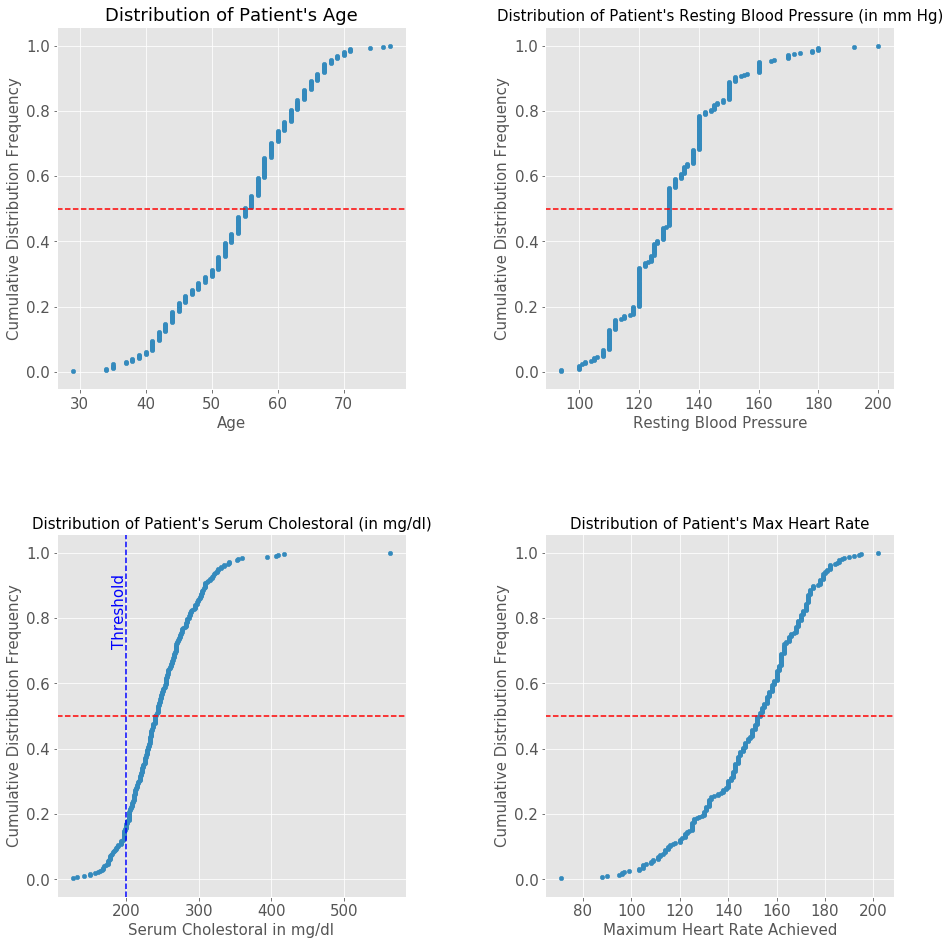

In [6]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,16), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# ax[0,0]
distribution_age.plot(kind='scatter',x='X', y='Y',ax=ax[0,0], fontsize=15)
ax[0,0].set_title("Distribution of Patient's Age", fontsize=18)
ax[0,0].set_xlabel('Age', fontsize=15)
ax[0,0].set_ylabel('Cumulative Distribution Frequency', fontsize=15)
ax[0,0].axhline(y=0.5, color='r', linestyle='--')

# ax[0,1]
distribution_trestbps.plot(kind='scatter', x='X', y='Y', ax=ax[0,1], fontsize=15)
ax[0,1].set_title("Distribution of Patient's Resting Blood Pressure (in mm Hg)", fontsize=15)
ax[0,1].set_xlabel('Resting Blood Pressure', fontsize=15)
ax[0,1].set_ylabel('Cumulative Distribution Frequency', fontsize=15)
ax[0,1].axhline(y=0.5, color='r', linestyle='--')

# ax[1,0]
distribution_chol.plot(kind='scatter',x='X', y='Y',ax=ax[1,0], fontsize=15)
ax[1,0].set_title("Distribution of Patient's Serum Cholestoral (in mg/dl)", fontsize=15)
ax[1,0].set_xlabel('Serum Cholestoral in mg/dl', fontsize=15)
ax[1,0].set_ylabel('Cumulative Distribution Frequency', fontsize=15)
ax[1,0].axhline(y=0.5, color='r', linestyle='--')
ax[1,0].axvline(x=200, color='b', linestyle='--')
ax[1,0].text(180,0.9, 'Threshold', fontsize=15, color='blue', rotation=90)


# ax[1,1]
distribution_thalach.plot(kind='scatter', x='X', y='Y', ax=ax[1,1], fontsize=15)
ax[1,1].set_title("Distribution of Patient's Max Heart Rate", fontsize=15)
ax[1,1].set_xlabel('Maximum Heart Rate Achieved', fontsize=15)
ax[1,1].set_ylabel('Cumulative Distribution Frequency', fontsize=15)
ax[1,1].axhline(y=0.5, color='r', linestyle='--')

Text(0, 0.5, 'Cumulative Distribution Frequency')

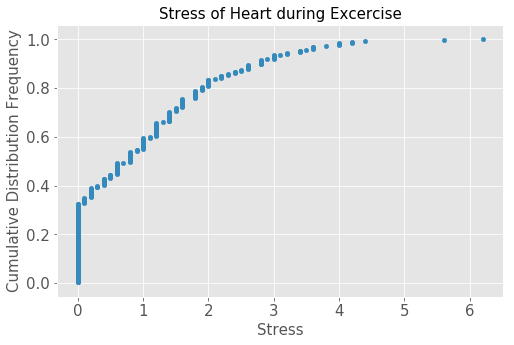

In [7]:
fig, ax = plt.subplots(figsize=(8,5))

# ax[1]
distribution_oldpeak.plot(kind='scatter', x='X', y='Y', ax=ax, fontsize=15)
ax.set_title("Stress of Heart during Excercise", fontsize=15)
ax.set_xlabel('Stress', fontsize=15)
ax.set_ylabel('Cumulative Distribution Frequency', fontsize=15)

**Categorical Features**

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4')]

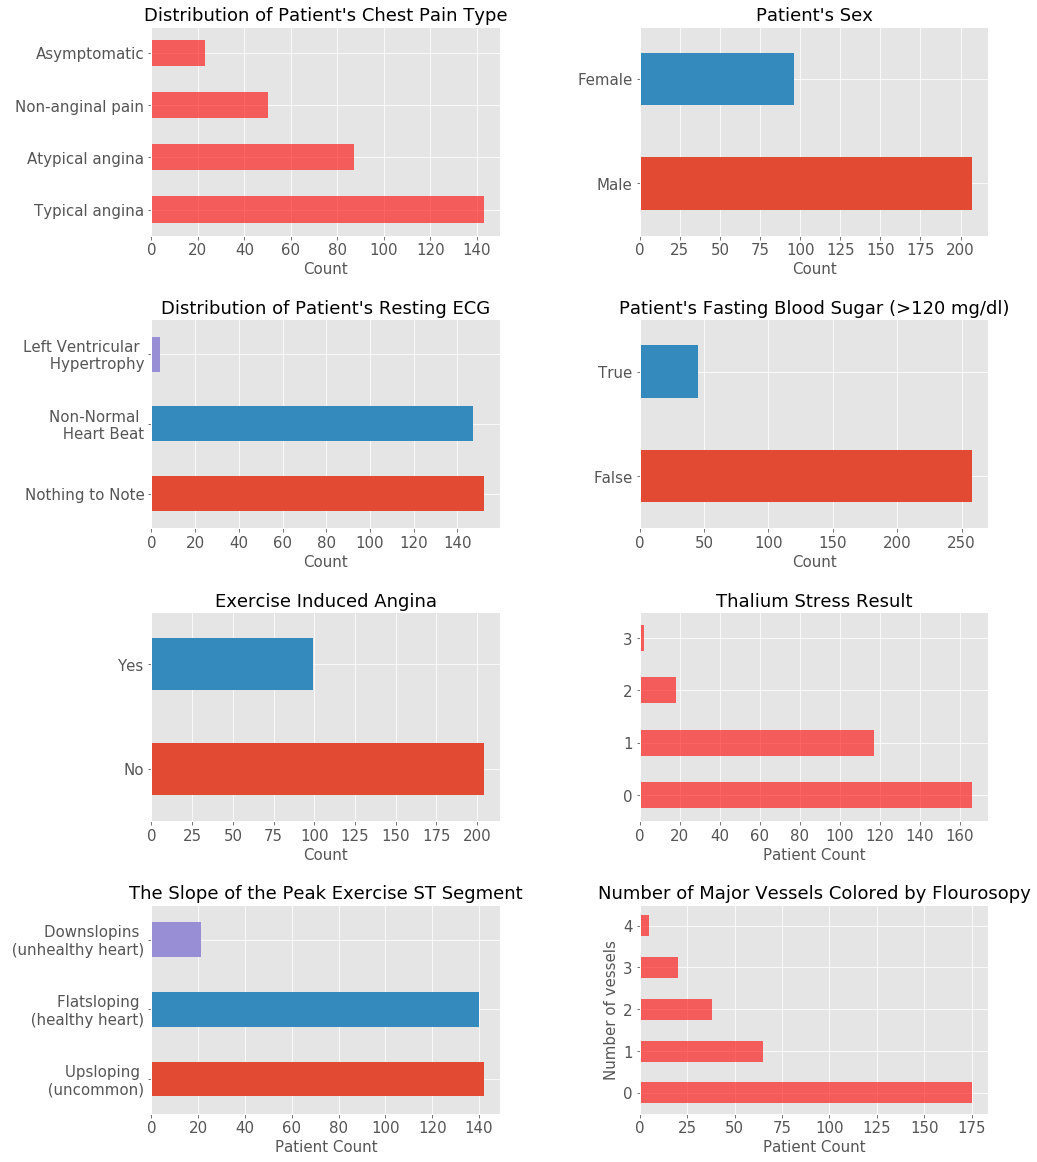

In [8]:
fig, ax = plt.subplots(figsize=(15,20), nrows=4, ncols=2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# ax[0,0]
chest_pain = heart['cp'].value_counts()
chest_pain.plot(kind='barh', ax=ax[0,0], fontsize=15, color=(1, 0, 0, 0.6))
ax[0,0].set_title("Distribution of Patient's Chest Pain Type", fontsize=18)
ax[0,0].set_xlabel('Count', fontsize=15)
cp_labels = ['Typical angina', 'Atypical angina', 'Non-anginal pain', 'Asymptomatic']
ax[0,0].set_yticklabels(cp_labels, fontsize=15)

# ax[0,1]
patient_sex = heart['sex'].value_counts()
labels = ['Male', 'Female']
patient_sex.plot(kind='barh', ax=ax[0,1], fontsize=15)
ax[0,1].set_title("Patient's Sex", fontsize=18)
ax[0,1].set_xlabel('Count', fontsize=15)
ax[0,1].set_yticklabels(labels)

# ax[1,0]
resting_ecg = heart['restecg'].value_counts()
resting_ecg.plot(kind='barh', ax=ax[1,0], fontsize=15)
ax[1,0].set_title("Distribution of Patient's Resting ECG", fontsize=18)
ax[1,0].set_xlabel('Count', fontsize=15)
ecg_labels = ['Nothing to Note', 'Non-Normal \n Heart Beat', 'Left Ventricular \n Hypertrophy'] 
ax[1,0].set_yticklabels(ecg_labels, fontsize=15)

# ax[1,1]
fbs = heart['fbs'].value_counts()
fbs.plot(kind='barh', ax=ax[1,1], fontsize=15)
ax[1,1].set_title("Patient's Fasting Blood Sugar (>120 mg/dl)", fontsize=18)
ax[1,1].set_xlabel('Count', fontsize=15)
ax[1,1].set_xticks
fbs_labels = ['False', 'True']
ax[1,1].set_yticklabels(fbs_labels)

# ax[2, 0]
excercise_angia = heart['exang'].value_counts()
excercise_angia.plot(kind='barh',ax=ax[2,0], fontsize=15)
ax[2,0].set_title("Exercise Induced Angina", fontsize=18)
ax[2,0].set_xlabel('Count', fontsize=15)
exang_labels = ['No','Yes']
ax[2,0].set_yticklabels(exang_labels, fontsize=15)

# ax[2,1]
thalium_stress = heart['thal'].value_counts()
thalium_stress.plot(kind='barh', ax=ax[2,1], fontsize=15, color=(1, 0, 0, 0.6))
ax[2,1].set_title("Thalium Stress Result", fontsize=18)
ax[2,1].set_xlabel('Patient Count', fontsize=15)
thal_labels = [0,1,2,3]
ax[2,1].set_yticklabels(thal_labels, fontsize=15)

# ax[3,0]
slope_excercise = heart['slope'].value_counts()
slope_excercise.plot(kind='barh', ax=ax[3,0], fontsize=15)
ax[3,0].set_title("The Slope of the Peak Exercise ST Segment", fontsize=18)
ax[3,0].set_xlabel('Patient Count', fontsize=15)
slope_labels=['Upsloping \n (uncommon)', 'Flatsloping \n (healthy heart)', 'Downslopins \n (unhealthy heart)']
ax[3,0].set_yticklabels(slope_labels, fontsize=15)

# ax[3, 1]
num_maj_vessels = heart['ca'].value_counts()
num_maj_vessels.plot(kind='barh', ax=ax[3,1], fontsize=15, color=(1, 0, 0, 0.6))
ax[3,1].set_title("Number of Major Vessels Colored by Flourosopy", fontsize=18)
ax[3,1].set_ylabel('Number of vessels', fontsize=15)
ax[3,1].set_xlabel('Patient Count', fontsize=15)
ca_labels = [0, 1, 2, 3, 4]
ax[3,1].set_yticklabels(ca_labels, fontsize=15)


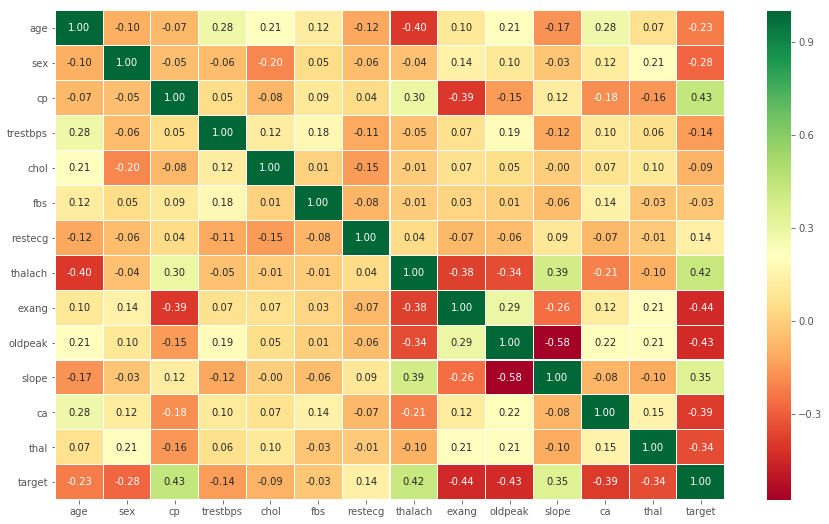

In [10]:
corr_matrix = heart.corr()
plt.figure(figsize=(15,9))
sns.heatmap(corr_matrix, annot=True, linewidths=0.05, fmt= '.2f',cmap='RdYlGn')

In [11]:
# Heart Disease by sex
disease_sex = heart.groupby('sex')['target'].count()
disease_sex.plot(kind=bar)

sex
0     96
1    207
Name: target, dtype: int64

# Split data into Train-Validation_Test

In [9]:
heart = heart.copy()

valid_test = heart.sample(frac=0.3)
valid = valid_test.sample(frac=0.5)
test = valid_test.drop(valid.index)

train = heart.drop(valid_test.index)

print(valid.shape)
print(test.shape)
print(train.shape)

(46, 14)
(45, 14)
(212, 14)


In [10]:
train_y = train['target']
valid_y = valid['target']
test_y = test['target']

In [11]:
train.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [12]:
train_X = train.drop('target', axis=1)
valid_X = valid.drop('target', axis=1)
test_X = test.drop('target', axis=1)

# Linear Classifier

## Logistic Regression

In [13]:
## Baseline: Majority class prediction
baseline = float(len(test[test['target']==1]))/len(test)
print('Baseline accuracy (majority class classifier): {}'.format(baseline))

Baseline accuracy (majority class classifier): 0.6444444444444445


In [14]:
# Instantiate model
lr_model_1 = LogisticRegression()

# Fit on training data
lr_model_1.fit(train_X, train_y)

# Save model
filename = 'lr_model_1.sav'
pickle.dump(lr_model_1, open(filename, 'wb'))

# Load model and predict
pickle.load(open(filename, 'rb'))
lr_trn_preds = lr_model_1.predict(train_X)
lr_valid_preds = lr_model_1.predict(valid_X)

**Metrics**

In [15]:
# Accuracy
lr_01_trn_acc = accuracy_score(train_y, lr_trn_preds )
lr_01_val_acc = accuracy_score(valid_y, lr_valid_preds)

# Precision
lr_01_trn_pre = precision_score(train_y, lr_trn_preds )
lr_01_val_pre = precision_score(valid_y, lr_valid_preds)

# Recall
lr_01_trn_recall = recall_score(train_y, lr_trn_preds )
lr_01_val_recall = recall_score(valid_y, lr_valid_preds)

# AUC
lr_01_trn_auc = roc_auc_score(train_y, lr_trn_preds)
lr_01_val_auc = roc_auc_score(valid_y, lr_valid_preds)

In [16]:
print('Train AUC: {}'.format(lr_01_trn_acc ))
print('Train AUC: {}'.format(lr_01_trn_auc))
print('Train Precision: {}'.format(lr_01_trn_pre))
print('Train Recall: {}'.format(lr_01_trn_recall))
print('*'*30)
print('Valid AUC: {}'.format(lr_01_val_acc))
print('Valid AUC: {}'.format(lr_01_val_auc))
print('Valid Precision: {}'.format(lr_01_val_pre))
print('Valid Recall: {}'.format(lr_01_val_recall))
#print('Test AUC: {}'.format(auc_test))

Train AUC: 0.8632075471698113
Train AUC: 0.8608955490143609
Train Precision: 0.8416666666666667
Train Recall: 0.9099099099099099
******************************
Valid AUC: 0.8043478260869565
Valid AUC: 0.8047619047619048
Valid Precision: 0.8333333333333334
Valid Recall: 0.8


## Fine Tune Logistic Regression

In [17]:
train_aucs = []
train_precision_scores = []
train_recall_scores = []

valid_aucs = []
valid_precision_scores = []
valid_recall_scores = []


Cs = [.00001, .00005, .0001,.0005,.001,.005,.01,.05, .1, .5, 1, 5, 10]

for ii in range(len(Cs)):
    C = Cs[ii]
    print('-'*50)
    print('C:', C)
    
    
    lr_model_02 = LogisticRegression(penalty= 'l2', C =C)
    
    lr_model_02.fit(train_X, train_y)
    
   
    model = lr_model_02
     #Predictions
    trn_preds = model.predict(train_X)
    valid_preds = model.predict(valid_X)
    
    # Metrics
    trn_auc = roc_auc_score(train_y, trn_preds)
    trn_pre_score = precision_score(train_y, trn_preds)
    trn_recall_score = recall_score(train_y, trn_preds)
    
    valid_auc = roc_auc_score(valid_y, valid_preds)
    valid_pre_score = precision_score(valid_y, valid_preds)
    valid_recall_score = recall_score(valid_y, valid_preds)
    
    # Append
    train_aucs.append(trn_auc)
    train_precision_scores.append(trn_pre_score)
    train_recall_scores.append(trn_recall_score)
    
    valid_aucs.append(valid_auc)
    valid_precision_scores.append(valid_pre_score)
    valid_recall_scores.append(valid_recall_score)
    
    print('Train AUC:%.3f' % trn_auc)
    print('Train Precision:%.3f' % trn_pre_score)
    print('Train Recall:%.3f' % trn_recall_score)
    print('-'*20)
    print('Valid AUC:%.3f' % valid_auc)
    print('Valid Precision:%.3f' % valid_pre_score)
    print('Valid Recall:%.3f' % valid_recall_score)

--------------------------------------------------
C: 1e-05
Train AUC:0.642
Train Precision:0.626
Train Recall:0.829
--------------------
Valid AUC:0.622
Valid Precision:0.643
Valid Recall:0.720
--------------------------------------------------
C: 5e-05
Train AUC:0.703
Train Precision:0.693
Train Recall:0.793
--------------------
Valid AUC:0.653
Valid Precision:0.696
Valid Recall:0.640
--------------------------------------------------
C: 0.0001
Train AUC:0.704
Train Precision:0.696
Train Recall:0.784
--------------------
Valid AUC:0.653
Valid Precision:0.696
Valid Recall:0.640
--------------------------------------------------
C: 0.0005
Train AUC:0.696
Train Precision:0.697
Train Recall:0.748
--------------------
Valid AUC:0.697
Valid Precision:0.739
Valid Recall:0.680
--------------------------------------------------
C: 0.001
Train AUC:0.696
Train Precision:0.697
Train Recall:0.748
--------------------
Valid AUC:0.697
Valid Precision:0.739
Valid Recall:0.680
-----------------------

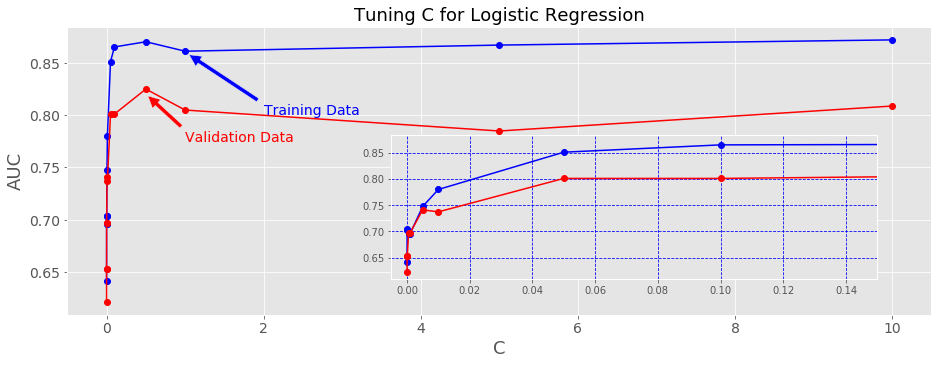

In [18]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax2 = fig.add_axes([0.4, 0.2, 0.45, 0.4])

ax1.plot(Cs, train_aucs, 'bo-', label='TRAIN')
ax1.plot(Cs, valid_aucs, 'ro-', label='VALID')
ax1.set_xlabel('C', fontsize=18)
ax1.set_ylabel('AUC', fontsize=18)
ax1.set_title('Tuning C for Logistic Regression', fontsize=18)
ax1.tick_params(axis='both', labelsize=14)
ax1.annotate('Training Data', xy=(1, 0.86), xytext=(2, 0.8),
            arrowprops=dict(facecolor='blue', shrink=0.05),fontsize=14, color='blue')

ax1.annotate('Validation Data', xy=(0.5, 0.82), xytext=(1, 0.775),
            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=14, color='red')


# Insert
ax2.plot(Cs, train_aucs, 'bo-')
ax2.plot(Cs, valid_aucs, 'ro-')
ax2.set_xlim(-0.005, 0.15)
# Grid
ax2.grid(True, color='b', linestyle='dashed')

In [19]:
model_best_C = LogisticRegression(penalty='l2', C=0.1)

results = model_best_C.fit(train_X, train_y)
print('Intercept: {}'.format(results.intercept_))
print('\n')

coeff_df = pd.DataFrame({'Features': train_X.columns.tolist(),
                         'Coefficients': results.coef_.flatten()}).sort_values(by='Coefficients', ascending=False).reset_index(drop=True)
print(coeff_df)
print('\n')
print('Score on train set: ', model.score(train_X, train_y))
print('Score on valid set: ', model.score(valid_X, valid_y))
print('Score on test set: ', model.score(test_X, test_y))

Intercept: [0.03762418]


    Features  Coefficients
0         cp      0.545026
1    restecg      0.272370
2      slope      0.170567
3        fbs      0.041508
4    thalach      0.038678
5        age      0.017748
6       chol     -0.005312
7   trestbps     -0.027054
8      exang     -0.379591
9    oldpeak     -0.476298
10      thal     -0.586088
11        ca     -0.606718
12       sex     -0.695096


Score on train set:  0.8726415094339622
Score on valid set:  0.8043478260869565
Score on test set:  0.6888888888888889


# precision-recall tradeoff

We will explore the trade-off between precision and recall. We first examine what happens when we use a different threshold value for making class predictions. We then explore a range of threshold values and plot the associated precision-recall curve.

## Varying the threshold

**FALSE NEGATIVES** - Predicting someone as healthly (NO HEART DISEASE) when the person is actually having one - are costly mistakes in our case. So we want to be less conservative about making negative predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a lower threshold. 

In [20]:
def apply_threshold(probabilities, threshold):
    prediction = pd.Series(probabilities).apply(lambda probability: +1 if probability > threshold else 0)
    return prediction

Using the best model, let's compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then we will use thresholds set at 0.5 (default) and 0.2 to make predictions from these probability values.

In [21]:
# sckit-learn predict_proba will return probablity values for class 0 and 1
probabilities = model_best_C.predict_proba(valid_X)[:,1]

In [22]:
# predictions at threshold 0.5
prediction_1 = apply_threshold(probabilities, 0.5)
sum(prediction_1==1)

26

In [23]:
# predictions at threshold 0.1
prediction_2 = apply_threshold(probabilities, 0.1)
sum(prediction_2==1)

33

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. At a very low threshold, we would predict most of the patients having Heart Disease, hence the recall will be very high close to 1.0. However doing so will compromise the precision of the model. Recall that in the formula for precision the number of positive predictions is in the denominator and when this value increases the precision drops.

**Compute precision and recall for threshold values 0.1 and 0.5.**

In [24]:
# Precision at threshold 0.5
precision_1 = precision_score(valid_y, prediction_1)
print(precision_1)

# Precision at threshold 0.1
precision_2 = precision_score(valid_y, prediction_2)
print(precision_2)

# Recall at threshold 0.5
recall_1 = recall_score(valid_y, prediction_1) 
print(recall_1)

# Recall at threshold 0.1
recall_2 = recall_score(valid_y, prediction_2)
print(recall_2)

0.8076923076923077
0.696969696969697
0.84
0.92


## Precision-recall curve

At different values of thresholds, let's compute the precision and recall scores, and then plot the precision-recall curve.

In [25]:
threshold_values = np.linspace(0.1, 0.5, num = 100)
print(threshold_values)

[0.1        0.1040404  0.10808081 0.11212121 0.11616162 0.12020202
 0.12424242 0.12828283 0.13232323 0.13636364 0.14040404 0.14444444
 0.14848485 0.15252525 0.15656566 0.16060606 0.16464646 0.16868687
 0.17272727 0.17676768 0.18080808 0.18484848 0.18888889 0.19292929
 0.1969697  0.2010101  0.20505051 0.20909091 0.21313131 0.21717172
 0.22121212 0.22525253 0.22929293 0.23333333 0.23737374 0.24141414
 0.24545455 0.24949495 0.25353535 0.25757576 0.26161616 0.26565657
 0.26969697 0.27373737 0.27777778 0.28181818 0.28585859 0.28989899
 0.29393939 0.2979798  0.3020202  0.30606061 0.31010101 0.31414141
 0.31818182 0.32222222 0.32626263 0.33030303 0.33434343 0.33838384
 0.34242424 0.34646465 0.35050505 0.35454545 0.35858586 0.36262626
 0.36666667 0.37070707 0.37474747 0.37878788 0.38282828 0.38686869
 0.39090909 0.39494949 0.3989899  0.4030303  0.40707071 0.41111111
 0.41515152 0.41919192 0.42323232 0.42727273 0.43131313 0.43535354
 0.43939394 0.44343434 0.44747475 0.45151515 0.45555556 0.4595

In [26]:
precision_all = [precision_score(valid_y, apply_threshold(
    probabilities, threshold)) for threshold in threshold_values]
recall_all = [recall_score(valid_y, apply_threshold(
    probabilities, threshold)) for threshold in threshold_values]

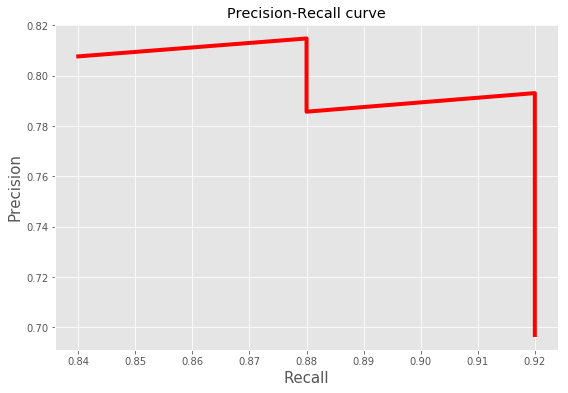

In [27]:
def plot_pr_curve(precision, recall):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(recall, precision, 'b-', linewidth=4.0, color = 'red')
    ax.set_title('Precision-Recall curve')
    ax.set_xlabel('Recall', fontsize=15)
    ax.set_ylabel('Precision', fontsize=15)
    
plot_pr_curve(precision_all, recall_all, )

In [34]:
new_thresholds = []

for i in zip(threshold_values, precision_all):
    thre, preci = i

    if preci >= 0.8:
        new_thresholds.append((thre))
print(min(new_thresholds))

0.31414141414141417


In [35]:
test_probabilities = model_best_C.predict_proba(test_X)[:,1]

# Confusion matrix at optimum threshold
cmat = confusion_matrix(y_true=test_y,
                        y_pred=apply_threshold(test_probabilities, 0.5),
                        labels=model_best_C.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))


 target_label | predicted_label | count 
--------------+-----------------+-------
      0       |        0        |     9
      0       |        1        |     7
      1       |        0        |     6
      1       |        1        |    23


In [36]:
# Confusion matrix at optimum threshold
cmat_optimum = confusion_matrix(y_true=test_y,
                        y_pred=apply_threshold(test_probabilities, 0.31),
                        labels=model_best_C.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat_optimum[i,j]))


 target_label | predicted_label | count 
--------------+-----------------+-------
      0       |        0        |     9
      0       |        1        |     7
      1       |        0        |     3
      1       |        1        |    26


# Readings 

## Recommended papers

* [Detrano R et al. 1989](https://www.ncbi.nlm.nih.gov/pubmed/2756873): International application of a new probability algorithm for the diagnosis of coronary artery disease
* [Al'Aref SJ et al. 2018](https://www.ncbi.nlm.nih.gov/pubmed/30060039): Clinical applications of machine learning in cardiovascular disease and its relevance to cardiac imaging